# Subjective Dataset

In [1]:
import sys
sys.path.append('../')
import torch
import numpy as np
import utils

In [2]:
from model import Model
from dataset_class import SubjectivityDataset
from evaluation import EvaluationClassification
import acquisition
import estimators
import metrics
import visualize
import ase

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
prompt_respond = f"""Is the following sentence `objective` or `subjective`. Respond with `objective` or `subjective`.\n"""

In [4]:
dataset_file = 'subj'

## LLaMa2 70B

In [6]:
model_file = "llama2_70b"

In [ ]:
llama = Model(model_name="Llama-2-70b",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt_respond,
                    device=device)

In [ ]:
subjective_dataset = SubjectivityDataset(dataset_file=dataset_file)
subjective_dataset.load(llama.prompt, llama.model.tokenizer, device)

In [13]:
llama_evaluation = EvaluationClassification(llama,
                                            subjective_dataset,
                                            device)

In [11]:
llama_evaluation.evaluation_procedure('active', 10, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [19:07<00:00,  1.43s/it]

Accuracy: 0.5523750185966492 - Loss: 0.6872297525405884


In [ ]:
llama_evaluation.evaluation_icl_procedure('active', nb_icl_examples=50, save=True, batch_size=1, version=1)

## Llama2 7B

In [ ]:
model_file = "llama2_7b"

In [6]:
llama = Model(model_name="Llama-2-7b-8bit",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt_respond,
                    device=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
subjective_dataset = SubjectivityDataset(dataset_file=dataset_file)
subjective_dataset.load(llama.prompt, llama.model.tokenizer, device)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [8]:
llama_evaluation = EvaluationClassification(llama,
                                            subjective_dataset,
                                            device)

In [13]:
llama_evaluation.evaluation_procedure('active', batch_size=30, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [05:22<00:00,  1.21s/it]

Accuracy: 0.4933750033378601 - Loss: 0.7332199215888977


In [11]:
llama_evaluation.evaluation_icl_procedure('active', nb_icl_examples=50, save=True, batch_size=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [1:43:54<00:00,  1.28it/s]

Accuracy: 0.7804999947547913 - Loss: 0.4667343199253082


## Acquisition

In [5]:
STEP = 1
RUNS = 3_000
SIZE = 400

### LURE-based Active Testing

In [15]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file="llama2_70b_icl50",
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
llama_acquisition.run_estimation(0.1)

100%|██████████| 3000/3000 [05:10<00:00,  9.66it/s]


In [8]:
phi_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file='llama2_7b_icl50',
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
phi_acquisition.get_coverage_estimation(n_runs=100)

100%|██████████| 100/100 [50:25<00:00, 30.26s/it]


### Active testing with no weight

In [ ]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            estimator=estimators.iidEstimator,
                                                            temperature=None)
llama_acquisition.run_estimation(coverage_probability=0.1)

### I.I.D.

In [18]:
llama_acquisition = acquisition.iidAcquisition(step=STEP,
                                                runs=RUNS,
                                                size=SIZE,
                                                eps=1e-15,
                                                model_file='llama2_70b_icl50',
                                                dataset_file=dataset_file,
                                                loss=metrics.cross_entropy_loss)
llama_acquisition.run_estimation()

### ASE

In [8]:
ase_estimator = ase.ActiveSurrogateEstimator(model_file="llama2_7b_icl50",
                                            surrogate_file="llama2_70b_icl50",
                                            dataset_file=dataset_file,
                                            loss=metrics.cross_entropy_loss)
ase_estimator.zero_shot_estimate()

## Figures

In [6]:
visualize.setup_matplotlib()

In [7]:
true_error = utils.load_tensors(f'subj/llama2_70b_icl50/full_set_loss').numpy()

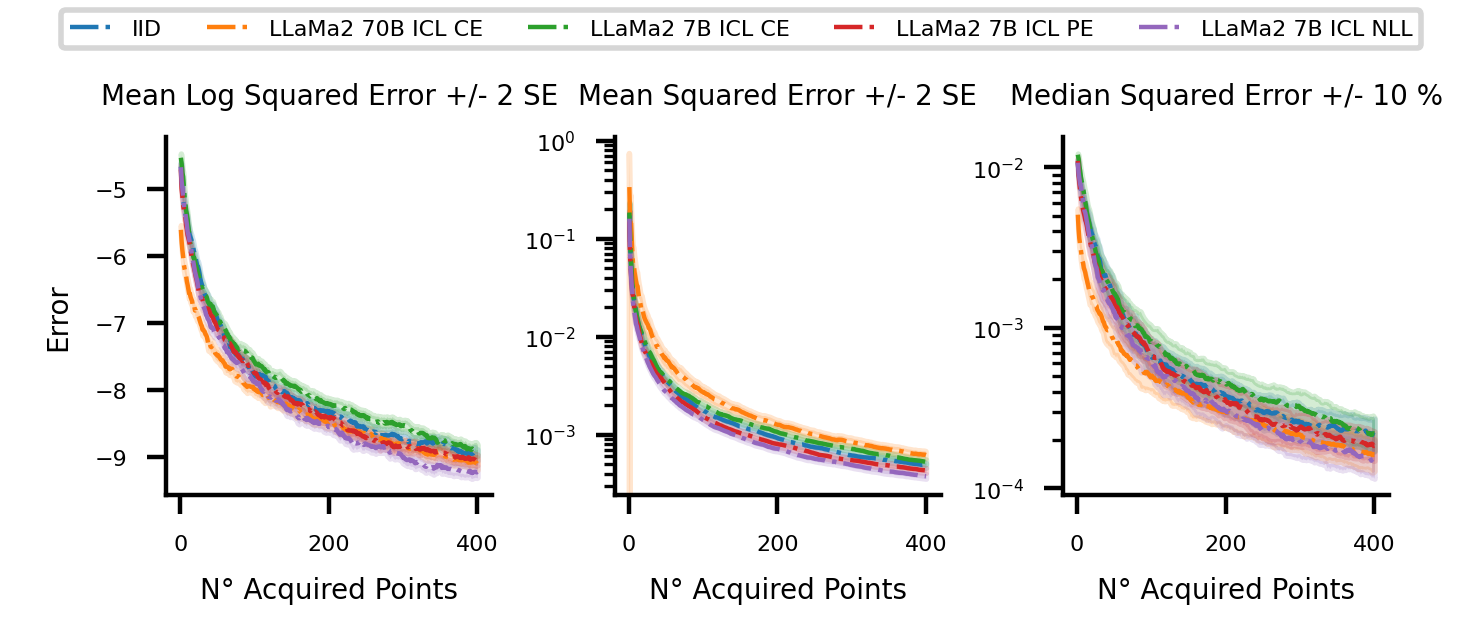

In [8]:
res_dict = {
    'IID': utils.load_arrays('subj/llama2_70b_icl50/llama2_70b_icl50_iid_loss'),
    'LLaMa2 70B ICL CE': utils.load_arrays('subj/llama2_70b_icl50/llama2_70b_icl50_llama2_70b_icl50_loss'), 
    'LLaMa2 7B ICL CE': utils.load_arrays('subj/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss'), 
    'LLaMa2 7B ICL PE': utils.load_arrays('subj/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_entropy'), 
    'LLaMa2 7B ICL NLL': utils.load_arrays('subj/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_nll'), 
}
visualize.plot_all_errors(res_dict, true_error, STEP, title='', savefig=(False, ''))